In [86]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [87]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/open.zip'

In [88]:
'''
dataset download & unzip
'''
# %%bash
!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000075/data/dataset.tar.gz

!tar -xvf 'dataset.tar.gz' -C '/content/'
!rm 'dataset.tar.gz'

from IPython.display import clear_output
clear_output()

In [89]:
'''
Preprocessing
범찬님 코드에 index_col만 추가했습니다
'''
import torch
import pandas as pd
import numpy as np
import re
import os
import tqdm

# Pre processing

class PreProcessor():

    def __init__(self, csv_path, index_col = True):
        self.values = pd.read_csv(csv_path, index_col = 0).values[:, :-1] # 출처를 제외한 모든 정보를 가져옴
        self.result = []
        self.index_col = index_col

    def _run_part(self, str_):

        str_ = re.sub("[“‘’”\"]","\'", str_) # unify different quotation marks
        str_ = re.sub("[\[{(（［｛〔]","(", str_) # unify different brackets
        str_ = re.sub("[\]})）］｝〕]",")", str_)
        str_ = re.sub("\({2,}","(", str_)
        str_ = re.sub("\){2,}",")", str_)

        str_ = re.sub("[〈《「『【]","《", str_) # unify different brackets
        str_ = re.sub("[〉》」』】]","》", str_)
        str_ = re.sub("《{2,}","《", str_)
        str_ = re.sub("》{2,}","》", str_)

        str_ = re.sub("·",", ",str_)

        str_ = re.sub("[^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣぁ-ゔァ-ヴー々〆〤一-龥\'\-~.,?!()《》 ]", "", str_) # remove special chars
        str_ = re.sub("\.{2,}",".", str_) # multiple punkts to one. 
        str_ = re.sub(" {2,}"," ", str_) # multiple blanks to one. 

        str_ = re.sub("\'{2,}","\'", str_) # remove duplicated quotation marks
        
        return str_

    def _tokenize(self, entity, target):

        type_ = entity["type"]
        word = entity["word"]

        # return "[" + type_ + "]" + word + "[/" + type_ + "]"
        return "[" + target + "]" + word + "[/" + target + "]"


    def _run_by_step(self, idx):

        sentence = self.values[idx, 0]
        sbj = eval(self.values[idx, 1]) # dict {word, start_idx, end_idx, type}
        obj = eval(self.values[idx, 2]) # dict {word, start_idx, end_idx, type}
        label = self.values[idx, 3]

        sub_first_flag = 1 if sbj["start_idx"] < obj['start_idx'] else 0 # if subject comes first 1 else 0

        # split the sentence
        if sub_first_flag:
            part_a = sentence[:sbj["start_idx"]]
            part_b = sentence[sbj['end_idx']+1 : obj['start_idx']]
            part_c = sentence[obj["end_idx"]+1 :]

        else:
            part_a = sentence[:obj["start_idx"]]
            part_b = sentence[obj['end_idx']+1 : sbj['start_idx']]
            part_c = sentence[sbj["end_idx"]+1 :]

        part_a = self._run_part(part_a).lstrip()
        part_b = self._run_part(part_b)
        part_c = self._run_part(part_c).rstrip()

        sub_token = self._tokenize(sbj, 'SUB')
        obj_token = self._tokenize(obj, 'OBJ')

        # concatenate the parts
        if sub_first_flag:
            sentence = part_a + sub_token + part_b + obj_token + part_c
        else:
            sentence = part_a + obj_token + part_b + sub_token + part_c

        if self.index_col:
            return [idx, sentence, sbj, obj, label]
        else:
            return [sentence, sbj, obj, label]

    def run(self, save_csv):

        for record_idx in range(len(self.values)):
            record = self._run_by_step(record_idx)
            self.result.append(record)

        print("preprocessing done!")

        if self.index_col:
            col_list = ["id", "sentence", "sub_entity", "obj_entity", "label"]
            pd.DataFrame(self.result, columns = col_list).to_csv(save_csv, index=False)
        else:
            col_list = ["sentence", "sub_entity", "obj_entity", "label"]
            pd.DataFrame(self.result, columns = col_list).to_csv(save_csv)
        

p = PreProcessor('/content/dataset/train/train.csv')
p.run('preprocessed.csv')

preprocessing done!


In [90]:
import pandas as pd
train_data = pd.read_csv('/content/preprocessed.csv', index_col=0)
train_data.head()

,sentence,sub_entity,obj_entity,label
id,,,,
0,《Something》는 [OBJ]조지 해리슨[/OBJ]이 쓰고 [SUB]비틀즈[/S...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation
1,"호남이 기반인 바른미래당, [OBJ]대안신당[/OBJ], [SUB]민주평화당[/SU...","{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation
2,K리그2에서 성적 1위를 달리고 있는 [SUB]광주FC[/SUB]는 지난 26일 [...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of
3,균일가 생활용품점 (주)[SUB]아성다이소[/SUB](대표 [OBJ]박정부[/OBJ...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees
4,[OBJ]1967[/OBJ]년 프로 야구 드래프트 1순위로 [SUB]요미우리 자이언...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation


In [91]:
'''
label dict download & unzip
'''

!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000075/data/code.tar.gz
!tar -xvf 'code.tar.gz' -C '/content/'
!rm 'code.tar.gz'

from IPython.display import clear_output
clear_output()

In [92]:
'''
loading label dict
'''

import pickle

with open('/content/code/dict_label_to_num.pkl', 'rb') as f:
    label_to_num = pickle.load(f)

with open('/content/code/dict_num_to_label.pkl', 'rb') as f:
    num_to_label = pickle.load(f)

print(label_to_num)
print(num_to_label)

{'no_relation': 0, 'org:top_members/employees': 1, 'org:members': 2, 'org:product': 3, 'per:title': 4, 'org:alternate_names': 5, 'per:employee_of': 6, 'org:place_of_headquarters': 7, 'per:product': 8, 'org:number_of_employees/members': 9, 'per:children': 10, 'per:place_of_residence': 11, 'per:alternate_names': 12, 'per:other_family': 13, 'per:colleagues': 14, 'per:origin': 15, 'per:siblings': 16, 'per:spouse': 17, 'org:founded': 18, 'org:political/religious_affiliation': 19, 'org:member_of': 20, 'per:parents': 21, 'org:dissolved': 22, 'per:schools_attended': 23, 'per:date_of_death': 24, 'per:date_of_birth': 25, 'per:place_of_birth': 26, 'per:place_of_death': 27, 'org:founded_by': 28, 'per:religion': 29}
{0: 'no_relation', 1: 'org:top_members/employees', 2: 'org:members', 3: 'org:product', 4: 'per:title', 5: 'org:alternate_names', 6: 'per:employee_of', 7: 'org:place_of_headquarters', 8: 'per:product', 9: 'org:number_of_employees/members', 10: 'per:children', 11: 'per:place_of_residence'

문장 길이 예시: [《Something》는 [OBJ]조지 해리슨[/OBJ]이 쓰고 [SUB]비틀즈[/SUB]가 1969년 앨범 《Abbey Road》에 담은 노래다.] == 81개
문장 최대 길이: 475
문장 최소 길이: 36
문장 평균 길이: 118.994702802587


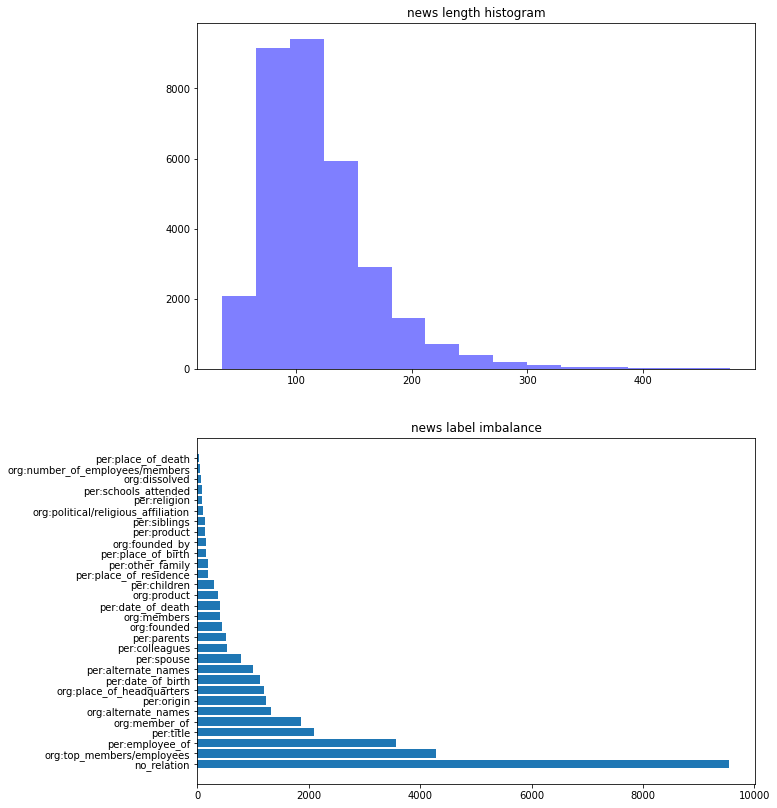

In [93]:
'''
EDA 시작!

1. data imbalance check
'''
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

len_of_news = [len(news) for news in train_data.sentence]
print(f'문장 길이 예시: [{train_data.sentence[0]}] == {len_of_news[0]}개')
print(f'문장 최대 길이: {max(len_of_news)}')
print(f'문장 최소 길이: {min(len_of_news)}')
print(f'문장 평균 길이: {np.average(len_of_news)}')

fig, axes = plt.subplots(2, 1, figsize=(10,14))
axes[0].hist(len_of_news, bins=15, color='b', alpha=0.5)
axes[0].set_title('news length histogram')

cnt = dict(Counter(train_data.label).most_common())
x, y = zip(*cnt.items())
axes[1].barh(x, y)
axes[1].set_title('news label imbalance')
plt.show()

# 번역기 API 시도
- 파파고, 카카오 번역기 api를 이용한 코드 구현은 성공
- 그러나 api 사용 제한이 턱없이 작아 다른 방식으로 우회하기로 함

In [94]:
#@title
'''
Papago Translator
'''

from typing import List
import os
import sys
from typing import List
import urllib.request
import requests
import json

class Translator:
    """
    지원 언어
    한국어(ko)
    영어(en)
    일본어(ja)
    중국어 간체(zh-CN)
    중국어 번체(zh-TW)
    베트남어(vi)
    인도네시아어(id)
    태국어(th)
    독일어(de)
    러시아어(ru)
    스페인어(es)
    이탈리아어(it)
    프랑스어(fr)
    """

    def __init__(self):
        self.__support_lang_list = [
            "ko",
            "en",
            "ja",
            "zh-CN",
            "zh-TW",
            "id",
            "th",
            "de",
            "ru",
            "es",
            "it",
            "fr",
        ]
        self.__support_lang_dict = {
            "ko": "한국어",
            "en": "영어",
            "ja": "일본어",
            "zh-CN": "중국어 번체",
            "zh-TW": "중국어 간체",
            "id": "인도네시아어",
            "th": "태국어",
            "de": "독일어",
            "ru": "러시아어",
            "es": "스페인어",
            "it": "이탈리아어",
            "fr": "프랑스어",
        }

    def translate(self, text: str, source: str, target: str) -> str:
        """
        Arguments:
        text : source text
        source : source language
        target : target language
        return translated text
        """
        assert source in self.__support_lang_list
        assert target in self.__support_lang_list
        assert source != target

        pass

    def translate_texts(self, texts: List[str], source: str, target: str) -> List[str]:
        """
        Arguments:
        texts : list of the source texts
        source : source language
        target : target language
        return list of the translated texts
        """
        translated_texts = list(
            map(lambda text: self.translate(text, source, target), texts)
        )
        return translated_texts

    def back_translate(self, text: str, source: str, target: str) -> str:
        """
        Arguments:
        text : source text
        source : source language
        target : target language
        return source language text translated from the target language.
        """
        translated_text = self.translate(text, source, target)
        back_translated_text = self.translate(translated_text, target, source)
        return back_translated_text

    def back_translate_texts(
        self, texts: List[str], source: str, target: str
    ) -> List[str]:
        """
        Arguments:
        texts : list of the source texts
        source : source language
        target : target language
        return list of the source language texts translated from the target language.
        """
        back_translated_texts = list(
            map(lambda text: self.back_translate(text, source, target), texts)
        )
        return back_translated_texts

    def get_support_lang(self):
        return self.__support_lang_dict.copy()

class PapagoTranslator(Translator):
    def __init__(self, client_id: str, client_secret: str):
        """
        client_id: 발급받은 Client ID 값
        client_secret: 발급받은 Client Secret 값
        발급 주소: https://developers.naver.com/main/
        """
        super().__init__()
        self.client_id = client_id
        self.client_secret = client_secret
        self.url = "https://openapi.naver.com/v1/papago/n2mt"

    def translate(self, text: str, source: str, target: str) -> str:
        super().translate(text=text, source=source, target=target)

        encText = urllib.parse.quote(text)
        data = f"source={source}&target={target}&text=" + encText
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id", self.client_id)
        request.add_header("X-Naver-Client-Secret", self.client_secret)
        response = urllib.request.urlopen(request, data=data.encode("utf-8"))
        rescode = response.getcode()

        if rescode == 200:
            response_body = response.read()
            decode = json.loads(response_body.decode("utf-8"))
            translated_text = decode["message"]["result"]["translatedText"]
        else:
            print("Error Code:" + rescode)

        return translated_text


# class KaKaoTranslator(Translator):
#     def __init__(self, rest_api_key):
#         """
#         rest_api_key: 발급 받은 REST API KEY
#         발급 주소: https://developers.kakao.com/
#         """
#         super().__init__()
#         self.url = "https://dapi.kakao.com/v2/translation/translate"
#         self.rest_api_key = rest_api_key

#     def translate(self, text: str, source: str, target: str) -> str:
#         super().translate(text=text, source=source, target=target)

#         source, target = self.__convert_lang_code(source, target)

#         params = {"query": text, "src_lang": source, "target_lang": target}
#         header = {"authorization": f"KakaoAK {self.rest_api_key}"}
#         response = requests.get(url=self.url, headers=header, params=params)

#         if response.status_code == 200:
#             decode = response.json()
#             translated_text = decode["translated_text"][0][0]
#         else:
#             print("Error Code:" + response.status_code)
#         return translated_text

#     def __convert_lang_code(self, source, target):
#         if source == "ko":
#             source = "kr"
#         elif source == "ja":
#             source = "jp"
#         elif source == "zh-TW" or source == "zh-CN":
#             source = "cn"

#         if target == "ko":
#             target = "kr"
#         elif target == "ja":
#             target = "jp"
#         elif target == "zh-TW" or target == "zh-CN":
#             target = "cn"

#         return source, target

In [95]:
client_id = "oy4eQquIKNzO52E9zyrQ"
client_secret = "XPjprxzEfb" # 발급 주소: https://developers.naver.com/main/

rest_api_key = "" # 발급 주소: https://developers.kakao.com/

ppg = PapagoTranslator(client_id, client_secret)
# kko = KaKaoTranslator(rest_api_key=rest_api_key)

print(ppg.get_support_lang())
# kko.get_support_lang_list() == ppg.get_support_lang_list()

# print(ppg.translate("안녕하세요.", "ko", "en"))
# print(ppg.translate_texts(["안녕하세요.", "번역기", "테스트입니다."], "ko", "ja"))
# print(ppg.back_translate("Welcome to the summoner's rift", "en", "ko"))

# texts = ["죽는 날까지 하늘을 우러러"
#          "한 점 부끄럼이 없기를",
#          "잎새에 이는 바람에도",
#          "나는 괴로워했다.",
#          "별을 노래하는 마음으로",
#          "모든 죽어 가는 것을 사랑해야지",
#          "그리고 나한테 주어진 길을",
#          "걸어가야겠다.",
#          "오늘 밤에도 별이 바람에 스치운다."]

# print(ppg.back_translate_texts(texts=texts, source="ko", target="en"))

{'ko': '한국어', 'en': '영어', 'ja': '일본어', 'zh-CN': '중국어 번체', 'zh-TW': '중국어 간체', 'id': '인도네시아어', 'th': '태국어', 'de': '독일어', 'ru': '러시아어', 'es': '스페인어', 'it': '이탈리아어', 'fr': '프랑스어'}


In [96]:
# from pprint import pprint

# data = train_data.sentence[204]
# pprint(data)
# pprint(ppg.back_translate(data, "ko", "en"))
# pprint(ppg.back_translate(data, "ko", "ja"))

# 재번역 전략 변경: Selenium 이용한 크롤링

- 구글 스프레드시트의 경우 GOOGLETRANSLATE(A1, "en", "ko") 등의 함수로 쉽게 번역이 가능하지만, 여러 가지를 시도해본 결과 번역물의 질이 떨어짐
    - 한-영-한: 성능이 떨어지고 문장의 구성성분이 굉장히 많이 잘림
    - 한-일-한: 성능은 더 낫지만 고유명사의 경우나 조사가 이상해지는 결과가 발생<br></br>

- 따라서 Selenium을 이용해 api 사용을 하지 않고 파파고 번역을 이용하기로 함
    - 한-영-한: 구글 번역보단 낫지만 역시 문장의 구성성분이 많이 잘림
    - 한-일-한: 성능도 좋고 고유명사와 조사를 거의 완벽하게 번역함<br></br>

- 번역을 하면 entity가 없어지거나 망가지는 문제 발생
    - 방법: 범찬님의 preprocessing 후 entity 옆에 붙는 토큰을 이용해 재번역을 거치면 토큰이 높은 확률로 남아 있음을 발견, 토큰을 이용해 entity를 살리자
    - 토큰들 사이의 단어들과 원래 entity의 similarity를 계산해 각각 단어들 자리에 원래 entity를 대체해 넣기<br></br>

- Selenium을 이용해 웹으로 번역하는데에 시간이 매우 많이 걸리는 문제 발생 (대략 2.5일)
    - Selenium으로 크롬 창을 하나만 띄워 크롤링을 진행할 경우, 번역기가 완벽하게 번역하는데에 걸리는 시간이 문장 당 최대 8~9초 정도 들게 됨
    - 또한 파파고는 번역을 시간에 걸쳐서 다듬는(?) 프로세스를 거치는 듯 하여 로딩 기준으로 시간을 설정할 수 없어 매우 비효율적으로 시간을 씀
    - 따라서 pathos.multiprocess를 이용해 멀티쓰레딩으로 시간을 가속함 (cpu 쓰레드 개수에 따라 다르겠지만 8쓰레드를 활용하는 경우 그대로 8배 가속 예상)<br></br>

# Types

한국어 개체명 정의 (한국해양대학교 - 컴퓨터공학과 자연언어처리 연구실) 을 참고함

https://github.com/kmounlp/NER/blob/master/NER%20Guideline%20(ver%201.0).pdf
<br></br>

### PER: 인명(person)

사람의 성씨나 이름(음차한 외국인의 이름, 영어, 한자, 일본어 등으로 표현된 외국인의 이름도 포함)에 해당한다. 그 밖에도 생물을 부르기 위해 붙인 이름, 별명으로 사용되는 말도 포함한다. 실존 인물, 신화/종교에 등장하는 인물, 만화/게임/소설/드라마 등에 등장하는 인물이나 존재에 대한 이름도 여기에 해당한다.
<br></br>

### ORG: 기관/조직(organization)

여러 사람이 속해서 이루어진 공동체로서 특정 집단을 지칭하는 단어이다. 화사명, 정부조직명, 위원회, 교육기관, 2명 이상의 구성원으로 활동하는 단체(볼 빨간 사춘기, 트와이스) 등이 기관/조직 범주에 속한다.
(사실 1인 기업이나 1인 그룹도 ORG로 분류함)
<br></br>

### LOC: 장소/위치(location)

국가명, 지역명칭과 행정 구역을 나타내는 단어가 여기에 속한다. 국가명이나 행정구역과는 별개의 산/강 같은 자연에 대한 거유명칭이나 관광명소, 경기장 등 특정 위치를 나타낼 수 있는 단어이다.
<br></br>

### DAT: 날짜(date)

절대적인 년, 월, 일에 관련된 표현이다. 기념일, 절기 처럼 특정 날짜를 지칭하는 표현도 여기에 속한다. 일요일, 월요일, 목요일 등 요일도 날짜에 속한다.
(기간은 DAT으로 태깅하지 않는다.)
<br></br>

### TIM: 시간(time)

절대적인 시, 분, 초에 관련된 표현이다. '정오'는 12시, '자정'은 00시에 해당하므로 TIM으로 태깅한다. '오전', '오후'는 해당하지 않는다.
<br></br>

### DUR: 기간(duration)

어떤 일이 지속되는 기간을 표현하는 말이다. '백악기', '쥐라기'와 같이 학문적으로 정의가 된 기간은 duration으로 태깅한다.
<br></br>

### MNY: 금액(money)

돈의 양을 나타내는 표현이다. (화폐단위 한정, 비트코인 이런거 안 됨...)
<br></br>

### PNT: 비율(rate)

백분율, 혹은 다른 수나 양에 대한 어떤 수나 양의 비(比)에 해당하는 표현이다
<br></br>

### POH: 기타 고유명사

제품명, 약품명, 특정 경기를 지칭하는 표현이나 행사, 회의, 사건 등을 나타내는 표현이다. 영화 제목, 노래 제목, 드라마 제목 등도 여기에 속한다. TV 채널 이름이나 일간지, 주간지 등도 POH로 태깅한다. 이메일 주소, 전화번호도 하나의 고유한 개체에 해당하므로 POH로 태깅한다.
(단, 날짜는 DAT으로 태깅)
<br></br>

### NOH: 기타 숫자표현

특정한 단위를 가지고 나이, 면적, 거리, 속도, 온도, 부피, 무게, 에너지 등의 양이나 정도를 표현하는 말이다.
<br></br>


In [97]:
'''
Restoring Entity in back-translated sentences
'''
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14ixfnVMqxSDCKzcRJcvVYWM8q6shu759' -O 'ppg_jp_backtrans.csv'

df_backtr = pd.read_csv("/content/ppg_jp_backtrans.csv", index_col=0)

--2021-10-05 02:46:10--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-10-05 02:46:10--  https://docs.google.com/uc?export=download&id=14ixfnVMqxSDCKzcRJcvVYWM8q6shu759
Resolving docs.google.com (docs.google.com)... 173.194.215.101, 173.194.215.100, 173.194.215.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f6ijpvh5b29l8497gst9nvnllsqheen0/1633401900000/11727180082408018277/*/14ixfnVMqxSDCKzcRJcvVYWM8q6shu759?e=download [following]
--2021-10-05 02:46:12--  https://doc-0g-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f6ijpvh5b29l8497gst9nvnllsqheen0/1633401900000/11727180082408018277/*/14ixfnVMqxSDCKzcRJcvVYWM8q6shu759?e=download
Resolving doc-0g-a0-docs.googleusercontent.co

In [123]:
import torch
import pandas as pd
import numpy as np
import re
import os
from tqdm.auto import tqdm

'''
token 추가를 뺀 preprocessing
'''

class PreProcessor_without_Token():

    def __init__(self, df, index_col = True):
        self.values = df  # 데이터프레임을 입력받음
        self.result = []
        self.index_col = index_col

    def _run_part(self, str_):

        str_ = re.sub("[“‘’”\"]","\'", str_) # unify different quotation marks
        str_ = re.sub("[\[{(（［｛〔]","(", str_) # unify different brackets
        str_ = re.sub("[\]})）］｝〕]",")", str_)
        str_ = re.sub("\({2,}","(", str_)
        str_ = re.sub("\){2,}",")", str_)

        str_ = re.sub("[〈《「『【]","《", str_) # unify different brackets
        str_ = re.sub("[〉》」』】]","》", str_)
        str_ = re.sub("《{2,}","《", str_)
        str_ = re.sub("》{2,}","》", str_)

        str_ = re.sub("·",", ",str_)

        str_ = re.sub("[^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣぁ-ゔァ-ヴー々〆〤一-龥\'\-~.,?!()《》 ]", "", str_) # remove special chars
        str_ = re.sub("\.{2,}",".", str_) # multiple punkts to one. 
        str_ = re.sub(" {2,}"," ", str_) # multiple blanks to one. 

        str_ = re.sub("\'{2,}","\'", str_) # remove duplicated quotation marks
        
        return str_

    def _run_by_step(self, idx):

        sentence = self.values[idx, 0]
        sbj = eval(self.values[idx, 1]) # dict {word, start_idx, end_idx, type}
        obj = eval(self.values[idx, 2]) # dict {word, start_idx, end_idx, type}
        label = self.values[idx, 3]

        sub_first_flag = 1 if sbj["start_idx"] < obj['start_idx'] else 0 # if subject comes first 1 else 0

        # split the sentence
        if sub_first_flag:
            part_a = sentence[:sbj["start_idx"]]
            part_b = sentence[sbj['end_idx']+1 : obj['start_idx']]
            part_c = sentence[obj["end_idx"]+1 :]

        else:
            part_a = sentence[:obj["start_idx"]]
            part_b = sentence[obj['end_idx']+1 : sbj['start_idx']]
            part_c = sentence[sbj["end_idx"]+1 :]

        part_a = self._run_part(part_a).lstrip()
        part_b = self._run_part(part_b)
        part_c = self._run_part(part_c).rstrip()

        sub_token = sbj['word']
        obj_token = obj['word']

        # concatenate the parts
        if sub_first_flag:
            sentence = part_a + sub_token + part_b + obj_token + part_c
        else:
            sentence = part_a + obj_token + part_b + sub_token + part_c

        if self.index_col:
            return [idx, sentence, sbj, obj, label]
        else:
            return [sentence, sbj, obj, label]

    def run(self, save_path):

        for record_idx in range(len(self.values)):
            record = self._run_by_step(record_idx)
            self.result.append(record)

        print("preprocessing done!")

        if self.index_col:
            col_list = ["id", "sentence", "sub_entity", "obj_entity", "label"]
            pd.DataFrame(self.result, columns = col_list).to_csv(save_path, index=False)
        else:
            col_list = ["sentence", "sub_entity", "obj_entity", "label"]
            pd.DataFrame(self.result, columns = col_list).to_csv(save_path)
        
train = pd.read_csv('/content/dataset/train/train.csv', index_col = 0).values[:, :-1]
p = PreProcessor_without_Token(train)
p.run(save_path = 'preprocessed_wo_token.csv')

preprocessing done!


In [110]:
import pandas as pd
import re
from tqdm.auto import tqdm

df_backtr = pd.read_csv("/content/ppg_jp_backtrans.csv", index_col=0)
df_backtr.loc[8025] = df_backtr.loc[8025].replace(np.nan, '[SUB] 조세희[SUB] (조세희, [OBJ] 1942년 8월 20일 [OBJ]~)는 대한민국의 소설가이다.')
df_backtr.loc[27495] = df_backtr.loc[27495].replace(np.nan, '한편 이날 회의에는 최재형 감사원장, 유은혜 부총리 겸 교육부 장관, 정경두 국방부 장관, 진영 행정안전부 장관, 이재갑 고용노동부 장관, 서훈현준 국가정보원장, 조성욱 공정거래위원장, 검찰위원장, 김성수 공정거래위원장, 검찰위원장, 검찰시장, 검찰위원장, 김성욱 공정거래위원장, 공정거래위원장, 공정거래위원장, 검찰위원장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청장, 국세청')
df_backtr.loc[31418] = df_backtr.loc[31418].replace(np.nan, '얀 모라벡(Jan Morvek, 1989년 11월 1일 프라하 ~ )은 체코의 축구 선수로, 현재 독일 [OBJ]분데스리가 [OBJ]의 클럽 [SUB]FC 샬케04 [SUB]와 체코 축구의 국가대표팀에 소속되어 있으며 공격형 미드필더이다.')
df_backtr.loc[31801] = df_backtr.loc[31801].replace(np.nan, "6·2 지방선거를 앞두고 야5당(민주당, SUB) 국민참여당(SUB), 창조한국당, 민주노동당, 진보신당) 등 4개 시민단체가 반MB연대를 목표로 '5·4회의'를 결성했으나 지방선거를 앞두고 잠정합의문을 거부하고 탈퇴한 진보신당은 노회찬 서울시장 후보가 독자 완주하고 심상정경기지사 후보(OBJ)를 사퇴한 유경기도지사 후보(OBJ)가 독자완주했다.")
df_backtr.loc[31802] = df_backtr.loc[31802].replace(np.nan, "마쓰이 히로오의 작품으로 2005년 일본 슈에이샤 잡지에 연재되었고 2007년 OBJ 애니메이션 OBJ로 리메이크화, 한국에서는 서울문화사를 통해 만화 단행본이 발행되었으며 애니메이션 시리즈는 2009년 8월 12일부터 2010년 1월 28일까지 SUB 투니버스를 통해 심야시간대에 일본어판으로 방송되었다.")

for i in range(df_backtr.shape[0]):
    df_backtr.loc[i].sentence = text_preprocess(df_backtr.loc[i].sentence)

print(df_backtr.head())

                                             sentence  ...                      label
id                                                     ...                           
0   Something은 (OBJ) 조지 해리슨(OBJ)이 쓰고 (SUB) 비틀즈(SUB...  ...                no_relation
1   호남이 기반인 바른미래당, OBJ 대안신당(OBJ) SUB 민주평화당(SUB)이 우...  ...                no_relation
2   K리그2에서 성적1위를 달리고 있는 (SUB)광주FC(SUB)는 26일 (OBJ)한...  ...              org:member_of
3   균일가 생활용품점 (SUB)아성다이소(SUB)(대표 (OBJ) 박근혜정부(OBJ)는...  ...  org:top_members/employees
4    1967년 프로야구 드래프트 1순위로 요미우리 자이언츠에 입단했고 등번호는 8번이었다.  ...                no_relation

[5 rows x 4 columns]


In [135]:
obj = re.compile(r"[《(]?OBJ[》)]?")
sub = re.compile(r"[《(]?SUB[》)]?")

df_backtr_processed = pd.DataFrame(columns=['id', 'sentence', 'sub_entity', 'obj_entity', 'label'])
id = 0
for i in tqdm(range(df_backtr.shape[0])):
    st = df_backtr.loc[i].sentence
    if len(obj.findall(st)) == 2 & len(sub.findall(st)) == 2:
        sub_dict = eval(df_backtr.loc[i].sub_entity)
        obj_dict = eval(df_backtr.loc[i].obj_entity)

        st_ = re.sub(r"[《(]?SUB[》)]?.*[《(]?SUB[》)]?", sub_dict['word'], st)
        st_processed = re.sub(r"[《(]?OBJ[》)]?.*[《(]?OBJ[》)]?", obj_dict['word'], st_)

        sub_dict['start_idx'] = st_processed.find(sub_dict['word'])
        sub_dict['end_idx'] = sub_dict['start_idx'] + len(sub_dict['word']) - 1
        obj_dict['start_idx'] = st_processed.find(obj_dict['word'])
        obj_dict['end_idx'] = obj_dict['start_idx'] + len(obj_dict['word']) - 1

        sr = pd.Series([id, st_processed, str(sub_dict), str(obj_dict), df_backtr.loc[i].label],
                       index=['id', 'sentence', 'sub_entity', 'obj_entity', 'label'])
        df_backtr_processed = df_backtr_processed.append(sr, ignore_index=True)
        id += 1

df_backtr_processed = df_backtr_processed.set_index('id').values[:, :]
p = PreProcessor_without_Token(df_backtr_processed)
p.run(save_path = 'ppg_jp_augmented.csv')

  0%|          | 0/32470 [00:00<?, ?it/s]

preprocessing done!


# Subject-Object entity 교체를 이용한 augmentation

- 몇몇 Label의 경우 Subject와 Object를 교체해도 Label이 그대로 이거나 다른 Label로 대체해 사용할 수 있는 경우를 발견함. 따라서 간단하게 Sub_entity와 Obj_entity를 교체해 data augmentation을 진행

- Label의 종류는 아래 표 참고
    - 

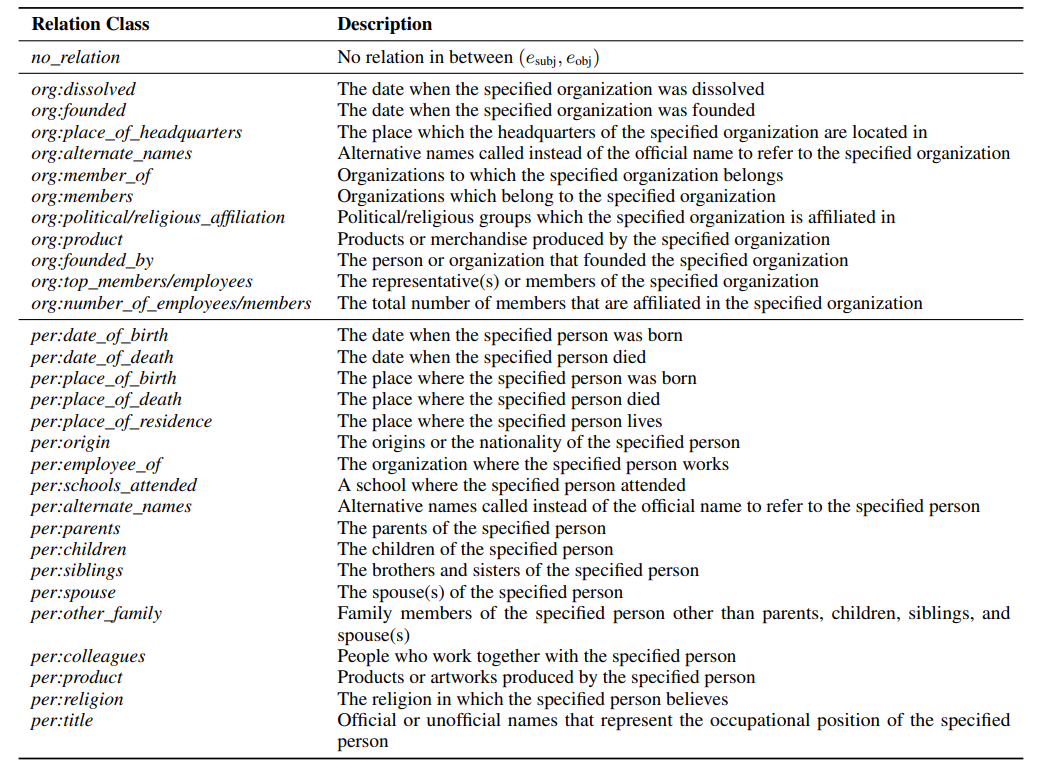

In [138]:
original_train = pd.read_csv('/content/preprocessed_wo_token.csv', index_col=0)
backtr_train = pd.read_csv('/content/ppg_jp_augmented.csv')
backtr_train['id'] = backtr_train['id'].apply(lambda x: x+original_train.shape[0])
backtr_train = backtr_train.set_index('id')
concated_train = pd.concat([original_train, backtr_train])

In [141]:
'''
Augmentation with entity change

ai stages 게시판의 강석민님의 글을 참고했습니다.
'''

def additional_data(dataframe):
    config = {
        "change_entity": {
            "sub_entity": "obj_entity",
            "obj_entity": "sub_entity",
        },
        "remain_label_list": [
            "no_relation",
            "org:members",
            "org:alternate_names",
            "per:children",
            "per:alternate_names",
            "per:other_family",
            "per:colleagues",
            "per:siblings",
            "per:spouse",
            "org:member_of",
            "per:parents",
            "org:top_members/employees",
        ],
        "change_values": {
            "org:member_of": "org:members",
            "org:members": "org:member_of",
            "per:parents": "per:children",
            "per:children": "per:parents",
            "org:top_members/employees": "per:employee_of",
        },
        "cols": ["sentence", "sub_entity", "obj_entity", "label"],
    }

    # 훈련 데이터를 불러오고 subject_entity와 object_entity만 바꾼다.
    add_data = dataframe.rename(columns=config["change_entity"])
    # 추가 데이터를 만들 수 있는 라벨만 남긴다
    add_data = add_data[add_data.label.isin(config["remain_label_list"])]
    # 속성 정렬을 해준다 (정렬을 안할경우 obj와 sub의 순서가 바뀌어 보기 불편함)
    add_data = add_data[config["cols"]]
    # 서로 반대되는 뜻을 가진 라벨을 바꿔준다.
    add_data = add_data.replace({"label": config["change_values"]})
    return add_data

def train_data_with_addition(dataframe):
    added_data = dataframe.append(additional_data(dataframe))
    added_data = added_data.drop_duplicates(subset=['sub_entity', 'obj_entity', 'sentence'], keep='first')  # 중복데이터 제거, 이미 존재할 경우 기존 학습데이터를 사용
    return added_data

final_augmented = train_data_with_addition(concated_train)
final_augmented.to_csv("final_augmented.csv", index=False)

In [146]:
final_augmented.head()

,sentence,sub_entity,obj_entity,label
id,,,,
0,《Something》는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation
1,"호남이 기반인 바른미래당, 대안신당, 민주평화당이 우여곡절 끝에 합당해 민생당(가칭...","{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation
2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of
3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees
4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation


문장 길이 예시: [id
0    《Something》는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...
0    《Something》는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...
Name: sentence, dtype: object] == 59개
문장 최대 길이: 458
문장 최소 길이: 12
문장 평균 길이: 94.63331390453986


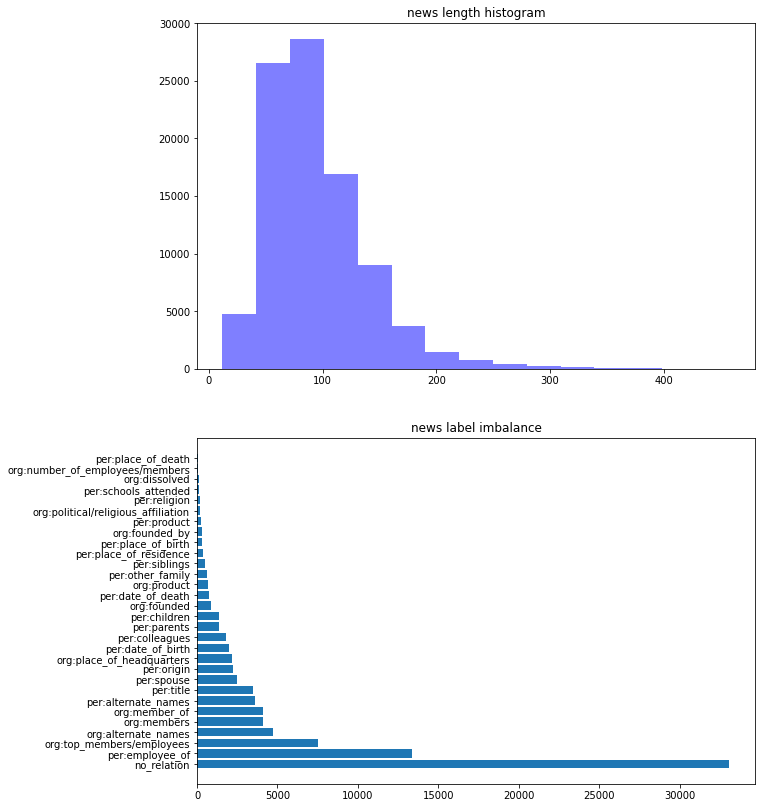

In [147]:
final_augmented.shape
len_of_news = [len(news) for news in final_augmented.sentence]
print(f'문장 길이 예시: [{final_augmented.sentence[0]}] == {len_of_news[0]}개')
print(f'문장 최대 길이: {max(len_of_news)}')
print(f'문장 최소 길이: {min(len_of_news)}')
print(f'문장 평균 길이: {np.average(len_of_news)}')

fig, axes = plt.subplots(2, 1, figsize=(10,14))
axes[0].hist(len_of_news, bins=15, color='b', alpha=0.5)
axes[0].set_title('news length histogram')

cnt = dict(Counter(final_augmented.label).most_common())
x, y = zip(*cnt.items())
axes[1].barh(x, y)
axes[1].set_title('news label imbalance')
plt.show()